In [13]:
%load_ext autoreload
%autoreload 2

# === Standard Libraries ===
import os
import sys
import random
import json
from typing import Any

# === Scientific Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

# === Signal Processing ===
import scipy
from scipy import signal
from scipy.signal import butter, filtfilt, correlate

# === Seismology Libraries ===
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

# === Machine Learning Libraries ===
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

# === PyTorch ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# === File Handling ===
import h5py

# === Custom Modules ===
module_path = os.path.abspath(os.path.join('../scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.model_selection import train_test_split
from neural_network_architectures import (
     QuakeXNet_1d, QuakeXNet_2d, SeismicCNN_1d, SeismicCNN_2d )


# === Seismology Client ===
client = Client('IRIS')

from utils import extract_waveforms
from utils import compute_spectrogram
from utils import normalize_spectrogram_minmax
from utils import return_train_val_loaders
from utils import plot_confusion_matrix_and_cr
from utils import train_model
from utils import WaveformPreprocessor


import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## I downloaded additional surface event data, the step below is just processing those additionally downloaded waveforms and these will be added later to the the total dataset. 

In [2]:
nos = 2000

# if we are taking all data or not. 
all_data = False

# the start point will be selected randomly from (start, -4)
start = - 40
shifting = True

# training parameters
train_split = 70                                      
val_split=20
test_split = 10
learning_rate=0.001
batch_size=128
n_epochs=60
dropout=0.4
criterion=nn.CrossEntropyLoss()


num_channels = 3
# new sampling rate
fs = 50

## filtering parameters
highcut = 20
lowcut = 1
input_window_length = 100

# randomly starting between -40 to -5s
start = -40

In [3]:
def process_surface_events(data_path, ids_path, fs=50, original_fs = 100, lowcut=1, highcut=20, window_length=100, taper_alpha=0.1, random_offset=(-40, -5)):
    """
    Processes surface event data by applying tapering, bandpass filtering, resampling, and normalization.
    
    Args:
        data_path (str): Path to the surface event data (.npy file).
        ids_path (str): Path to the surface event IDs (JSON file).
        fs (int): Sampling rate for resampling.
        lowcut (float): Low cutoff frequency for bandpass filter.
        highcut (float): High cutoff frequency for bandpass filter.
        window_length (int): Length of the waveform window (in seconds).
        taper_alpha (float): Alpha value for the Tukey window.
        random_offset (tuple): Range of random offsets for slicing data.
        
    Returns:
        list: Processed waveform data.
        list: Corresponding event IDs.
    """
    # Load data and IDs
    surface_data = np.load(data_path, allow_pickle=True)
    with open(ids_path, "r") as file:
        surface_ids = json.load(file)


    processed_data = []
    processed_ids = []

    # Process each event
    for i in tqdm(range(len(surface_data)), desc="Processing events"):
        try:
            event_data = surface_data[i]
            
            orig_fs = 100
            
            # Randomly select a window of the specified length
            random_shift = np.random.randint(random_offset[0], random_offset[1]) * orig_fs
            
            # assuming the onset at 90s
            start_idx = int(90 * orig_fs) + random_shift
            end_idx = start_idx + int(window_length * orig_fs)
            
    
            # Handle boundary conditions
            max_idx = event_data.shape[-1]
            if end_idx > max_idx:
                end_idx = max_idx
                start_idx = end_idx - int(window_length * orig_fs)
            if start_idx < 0:
                start_idx = 0
                end_idx = int(window_length * orig_fs)
                
                
            sliced = event_data[:, start_idx:end_idx]
            sliced_tensor = torch.tensor(sliced, dtype=torch.float32)

            
            processor = WaveformPreprocessor(
            input_fs=original_fs,
            target_fs=fs,
            lowcut=lowcut,
            highcut=highcut)
            
            processed = processor(sliced_tensor)  # (C, T)
          
        
            if processed.shape[-1] != int(window_length*fs):
                print('error')
                continue

            x = processed.numpy()
            
            if len(x) == 3:  # Ensure the event has three components
                processed_data.append(x)
                processed_ids.append(surface_ids[i])

        except Exception as e:
            # Log or print the exception if needed
            print(f"Error processing event {i}: {e}")
            continue

    return processed_data, processed_ids


# Example usage
data_path = '../../data/new_curated_surface_event_data.npy'
ids_path = '../../data/new_curated_surface_event_ids.json'

processed, processed_id = process_surface_events(data_path, ids_path)

Processing events: 100%|██████████| 6495/6495 [00:11<00:00, 555.05it/s]


In [4]:
#data files
file_noise="/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5";
file_comcat=  "/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5";
file_exotic="/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5";

# metadata
# accessing the comcat metadata
comcat_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
# comcat_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")

# accessing the exotic metadata
exotic_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
# exotic_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")

# accessing the data files
metadata_noise = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")
# metadata_noise = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")

# creating individual data frames for each class
cat_exp = comcat_metadata[comcat_metadata['source_type'] == 'explosion']
cat_eq = comcat_metadata[comcat_metadata['source_type'] == 'earthquake']
cat_su = exotic_metadata[exotic_metadata['source_type'] == 'surface event']
cat_noise = metadata_noise
cat_noise['event_id'] = [cat_noise['trace_start_time'][i]+'_noise' for i in range(len(cat_noise))]

In [5]:
## defining the threshold
SNR_THR = 1

# explosions
trace_snr_db_values = np.array([float(cat_exp.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_exp.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_exp = cat_exp.iloc[ii2]

# earthquake
trace_snr_db_values = np.array([float(cat_eq.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_eq.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_eq = cat_eq.iloc[ii2]

# surface events
trace_snr_db_values = np.array([float(cat_su.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_su.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR-2)[0].astype(int) 
df_su = cat_su.iloc[ii2]

# noise
# does not change
df_noise = cat_noise

In [6]:
number_data_per_class = len(df_su)
# surface events
d_su, id_su = extract_waveforms(df_su, file_exotic, input_window_length = input_window_length, fs=fs,
                                start =start, number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_su.shape)



number_data_per_class = 15000
# noise
d_noise, id_noise = extract_waveforms(df_noise, file_noise, input_window_length = input_window_length, fs=fs,
                                      start = start, number_data = number_data_per_class,
                                      num_channels = num_channels, shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_noise.shape)



number_data_per_class = len(df_exp)
# explosions
d_exp, id_exp = extract_waveforms(df_exp, file_comcat, input_window_length = input_window_length, fs=fs,
                                  start = start,  number_data = number_data_per_class, num_channels = num_channels,
                                  shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)

print(d_exp.shape)


number_data_per_class = 17000
# earthquakes
d_eq, id_eq = extract_waveforms(df_eq, file_comcat, input_window_length = input_window_length,  fs=fs,
                                start =start,  number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_eq.shape)

  0%|          | 9/15000 [00:00<02:57, 84.31it/s]

(3778, 3, 5000)


  0%|          | 4/13638 [00:00<05:55, 38.30it/s]

(10529, 3, 5000)


100%|██████████| 13638/13638 [03:35<00:00, 63.29it/s]


(8779, 3, 5000)


100%|██████████| 17000/17000 [04:30<00:00, 62.85it/s]


(10477, 3, 5000)


## Preparing the esec waveforms in standard format

In [9]:
df = pd.read_csv('../../data/curated_esec_catalog_for_retraining.csv',index_col = 0)

In [11]:
df

,event_id,station,prob_eq,prob_px,prob_noise,prob_surface,max_prob,assigned_label,snr_n,event_label_x,event_label_y,type
0,74,SLD,0.009431,0.606736,0.999952,0.979550,0.979550,surface,10.354430,surface,surface,rock avalanche
1,130,PLBC,0.002547,0.965852,0.999910,0.022586,0.965852,px,12.442687,px,px,rock avalanche
2,160,N19K,0.077101,0.220457,0.999976,0.766895,0.766895,surface,12.884728,surface,surface,ice avalanche
3,160,O18K,0.241163,0.072579,0.998638,0.925733,0.925733,surface,13.624922,surface,surface,ice avalanche
4,160,O19K,0.036180,0.535932,0.995490,0.585888,0.585888,surface,7.214448,surface,surface,ice avalanche
...,...,...,...,...,...,...,...,...,...,...,...,...
2251,227,D156,0.565975,0.729836,0.999775,0.040341,0.729836,px,8.105497,surface,surface,rock fall
2252,227,D160,0.705087,0.286322,0.999996,0.959258,0.959258,surface,9.703775,surface,surface,rock fall
2254,227,D163,0.000114,0.028818,0.999224,0.980757,0.980757,surface,22.175401,surface,surface,rock fall
2255,227,KBA,0.015515,0.234649,0.999980,0.906808,0.906808,surface,74.285297,surface,surface,rock fall


In [55]:
esec_data = []
esec_ids = []

for i in tqdm(range(len(df))):
    try:
        event_id = df['event_id'].iloc[i]
        station = df['station'].iloc[i]

        # Find all vertical component files for the event and station
        files = glob(f"../../data/iris_esec_waveforms/waveforms/{event_id}/*{station}*")

        if len(files) == 3:
            st = obspy.Stream()
            for file in files:
                st += obspy.read(file)
            
            
            st.resample(100)

            # Convert to NumPy array and clip length to 27000 samples (if possible)
            arr = np.stack([tr.data[:27000] for tr in st])
            esec_data.append(arr)
            esec_ids.append(event_id)

    except Exception as e:
        print(f"Error on index {i}, event {df['event_id'].iloc[i]}: {e}")
        continue


100%|██████████| 1866/1866 [00:31<00:00, 58.95it/s]


In [59]:
esec_data = np.array(esec_data)
esec_ids = np.array(esec_ids)

In [67]:
processed_data = []
processed_ids = []
random_offset=(-40, -5)
fs=50 
original_fs = 100
lowcut=1
highcut=20
window_length=100
taper_alpha=0.1
event_data = esec_data[i]
orig_fs = 100



event_data = esec_data[i]
random_shift = np.random.randint(random_offset[0], random_offset[1]) * orig_fs


# assuming the onset at 90s
start_idx = int(90 * orig_fs) + random_shift
end_idx = start_idx + int(window_length * orig_fs)
            
# Handle boundary conditions
max_idx = event_data.shape[-1]
if end_idx > max_idx:
    end_idx = max_idx
    start_idx = end_idx - int(window_length * orig_fs)
if start_idx < 0:
    start_idx = 0
    end_idx = int(window_length * orig_fs)
    
    
                
sliced = event_data[:, start_idx:end_idx]
sliced_tensor = torch.tensor(sliced, dtype=torch.float32)


processor = WaveformPreprocessor(
input_fs=original_fs,
target_fs=fs,
lowcut=lowcut,
highcut=highcut)

processed = processor(sliced_tensor)  # (C, T)


#if processed.shape[-1] != int(window_length*fs):
#    print('error')
#      continue

x = processed.numpy()

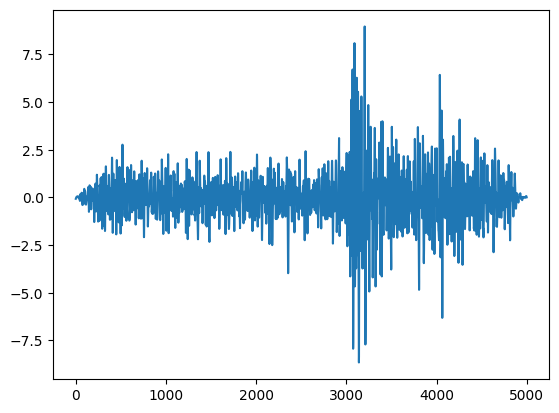

In [69]:
plt.plot(x[0])

In [ ]:
def process_surface_events(data_path, ids_path, fs=50, original_fs = 100, lowcut=1, highcut=20, window_length=100, taper_alpha=0.1, random_offset=(-40, -5)):
    """
    Processes surface event data by applying tapering, bandpass filtering, resampling, and normalization.
    
    Args:
        data_path (str): Path to the surface event data (.npy file).
        ids_path (str): Path to the surface event IDs (JSON file).
        fs (int): Sampling rate for resampling.
        lowcut (float): Low cutoff frequency for bandpass filter.
        highcut (float): High cutoff frequency for bandpass filter.
        window_length (int): Length of the waveform window (in seconds).
        taper_alpha (float): Alpha value for the Tukey window.
        random_offset (tuple): Range of random offsets for slicing data.
        
    Returns:
        list: Processed waveform data.
        list: Corresponding event IDs.
    """
    # Load data and IDs
    surface_data = np.load(data_path, allow_pickle=True)
    with open(ids_path, "r") as file:
        surface_ids = json.load(file)


    processed_data = []
    processed_ids = []

    # Process each event
    for i in tqdm(range(len(surface_data)), desc="Processing events"):
        try:
            event_data = surface_data[i]
            
            orig_fs = 100
            
            # Randomly select a window of the specified length
            random_shift = np.random.randint(random_offset[0], random_offset[1]) * orig_fs
            
            # assuming the onset at 90s
            start_idx = int(90 * orig_fs) + random_shift
            end_idx = start_idx + int(window_length * orig_fs)
            
    
            # Handle boundary conditions
            max_idx = event_data.shape[-1]
            if end_idx > max_idx:
                end_idx = max_idx
                start_idx = end_idx - int(window_length * orig_fs)
            if start_idx < 0:
                start_idx = 0
                end_idx = int(window_length * orig_fs)
                
                
            sliced = event_data[:, start_idx:end_idx]
            sliced_tensor = torch.tensor(sliced, dtype=torch.float32)

            
            processor = WaveformPreprocessor(
            input_fs=original_fs,
            target_fs=fs,
            lowcut=lowcut,
            highcut=highcut)
            
            processed = processor(sliced_tensor)  # (C, T)
          
        
            if processed.shape[-1] != int(window_length*fs):
                print('error')
                continue

            x = processed.numpy()
            
            if len(x) == 3:  # Ensure the event has three components
                processed_data.append(x)
                processed_ids.append(surface_ids[i])

        except Exception as e:
            # Log or print the exception if needed
            print(f"Error processing event {i}: {e}")
            continue

    return processed_data, processed_ids


# Example usage
data_path = '../../data/new_curated_surface_event_data.npy'
ids_path = '../../data/new_curated_surface_event_ids.json'

processed, processed_id = process_surface_events(data_path, ids_path)